In [3]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Sentinal 2 A&B Geomedian notebook

what does this notebook do? 

In [4]:
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''


    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [5]:
sensors= ['s2a_ard_granule', 's2b_ard_granule']

In [12]:

query_s = {
        'lat': (-30.700, -30.800),
        'lon': (144.900, 145.000),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-05-01', '2017-07-30')
        }

bands_of_int =['red','blue','green']

# use s2b_ard_granule 	 for S2B
data_S2A = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query_s)

In [13]:
data_S2A

<xarray.Dataset>
Dimensions:  (time: 9, x: 1057, y: 1212)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-01T00:21:11.026000 ...
  * y        (y) float64 -3.403e+06 -3.403e+06 -3.403e+06 -3.403e+06 ...
  * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
Data variables:
    red      (time, y, x) int16 2215 2261 2345 2457 2484 2477 2531 2288 2238 ...
    blue     (time, y, x) int16 2152 2286 2318 2335 2395 2543 2699 2593 2563 ...
    green    (time, y, x) int16 1968 2066 2126 2262 2379 2453 2546 2540 2502 ...
Attributes:
    crs:      EPSG:3577

In [2]:
help(s2aws.load)

Help on method load in module datacube.api.core:

load(product=None, measurements=None, output_crs=None, resolution=None, resampling=None, stack=False, dask_chunks=None, like=None, fuse_func=None, align=None, datasets=None, **query) method of datacube.api.core.Datacube instance
    Load data as an ``xarray`` object.  Each measurement will be a data variable in the :class:`xarray.Dataset`.
    
    See the `xarray documentation <http://xarray.pydata.org/en/stable/data-structures.html>`_ for usage of the
    :class:`xarray.Dataset` and :class:`xarray.DataArray` objects.
    
    **Product and Measurements**
        A product can be specified using the product name, or by search fields that uniquely describe a single
        product.
        ::
    
            product='ls5_ndvi_albers'
    
        See :meth:`list_products` for the list of products with their names and properties.
    
        A product can also be selected by searched using fields, but must only match one product.
     

In [6]:
data_sent = {}

for i in sensors:
    this_sensor = s2aws.load(product= i , group_by='solar_day', **query_s)
    
    #retreive projection infromation
    crs = this_sensor.crs
    crswkt = this_sensor.crs.wkt
    affine = this_sensor.affine
    
    #make a mask for full timeseries 
    #clear_pixels = this_sensor.pixel_quality == 1
    #clear_data = this_sensor.where(clear_pixels)
    
    data_sent[i] = clear_data

    

In [7]:
data_sent

{'s2a_ard_granule': <xarray.Dataset>
 Dimensions:        (time: 9, x: 1057, y: 1212)
 Coordinates:
   * time           (time) datetime64[ns] 2017-05-01T00:21:11.026000 ...
   * y              (y) float64 -3.403e+06 -3.403e+06 -3.403e+06 -3.403e+06 ...
   * x              (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
 Data variables:
     pixel_quality  (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     contiguity     (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     aerosol        (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     blue           (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     green          (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     red            (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     rededge1       (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
     rededge2       (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
  

In [8]:
data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine

In [9]:
data_sent

<xarray.Dataset>
Dimensions:        (time: 12, x: 1057, y: 1212)
Coordinates:
  * y              (y) float64 -3.403e+06 -3.403e+06 -3.403e+06 -3.403e+06 ...
  * x              (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
  * time           (time) datetime64[ns] 2017-05-01T00:21:11.026000 ...
Data variables:
    pixel_quality  (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    contiguity     (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    aerosol        (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    blue           (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    green          (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    red            (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    rededge1       (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    rededge2       (time, y, x) float64 nan nan nan nan nan nan nan nan nan ...
    rededge3       (time, y, x) flo

<IPython.core.display.Javascript object>


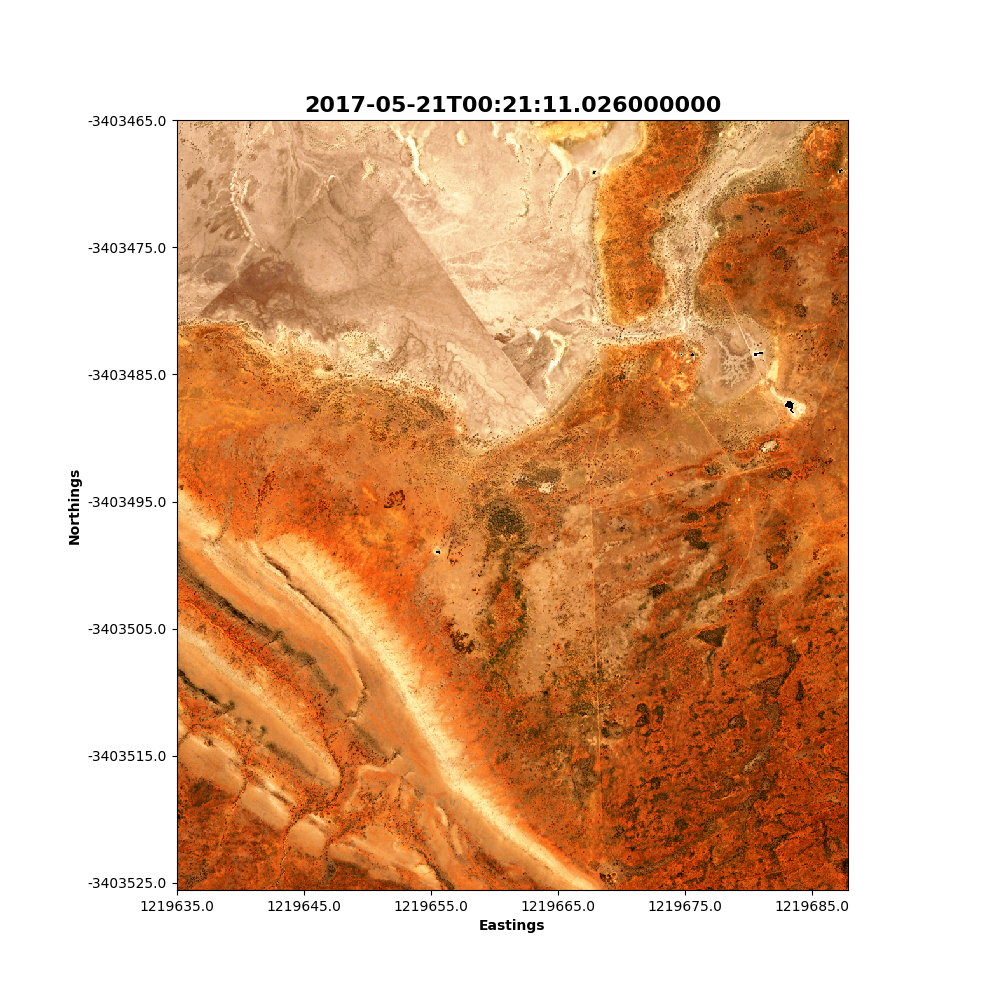

In [10]:
threeBandImage(data_sent, bands = ['red', 'green', 'blue'], time = 2)

In [22]:
#create a yearly mean 
sent_mean = data_sent.mean(dim = 'time')
cbr_NDVI = (sent_mean.nir1 - sent_mean.red)/(sent_mean.nir1 + sent_mean.red)
cbr_NDVI

<xarray.DataArray (y: 1212, x: 1057)>
array([[ 0.400577,  0.21599 ,  0.155067, ...,  0.394465,  0.4518  ,  0.455748],
       [ 0.172817,  0.150943,  0.142555, ...,  0.392894,  0.45802 ,  0.434924],
       [ 0.160772,  0.146126,  0.142748, ...,  0.366053,  0.401964,  0.387025],
       ..., 
       [ 0.238142,  0.25953 ,  0.359862, ...,  0.265493,  0.329166,  0.35908 ],
       [ 0.230829,  0.244987,  0.365764, ...,  0.279633,  0.267705,  0.247487],
       [ 0.233873,  0.229378,  0.317815, ...,  0.231169,  0.258306,  0.262583]])
Coordinates:
  * y        (y) float64 -3.403e+06 -3.403e+06 -3.403e+06 -3.403e+06 ...
  * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...

<IPython.core.display.Javascript object>


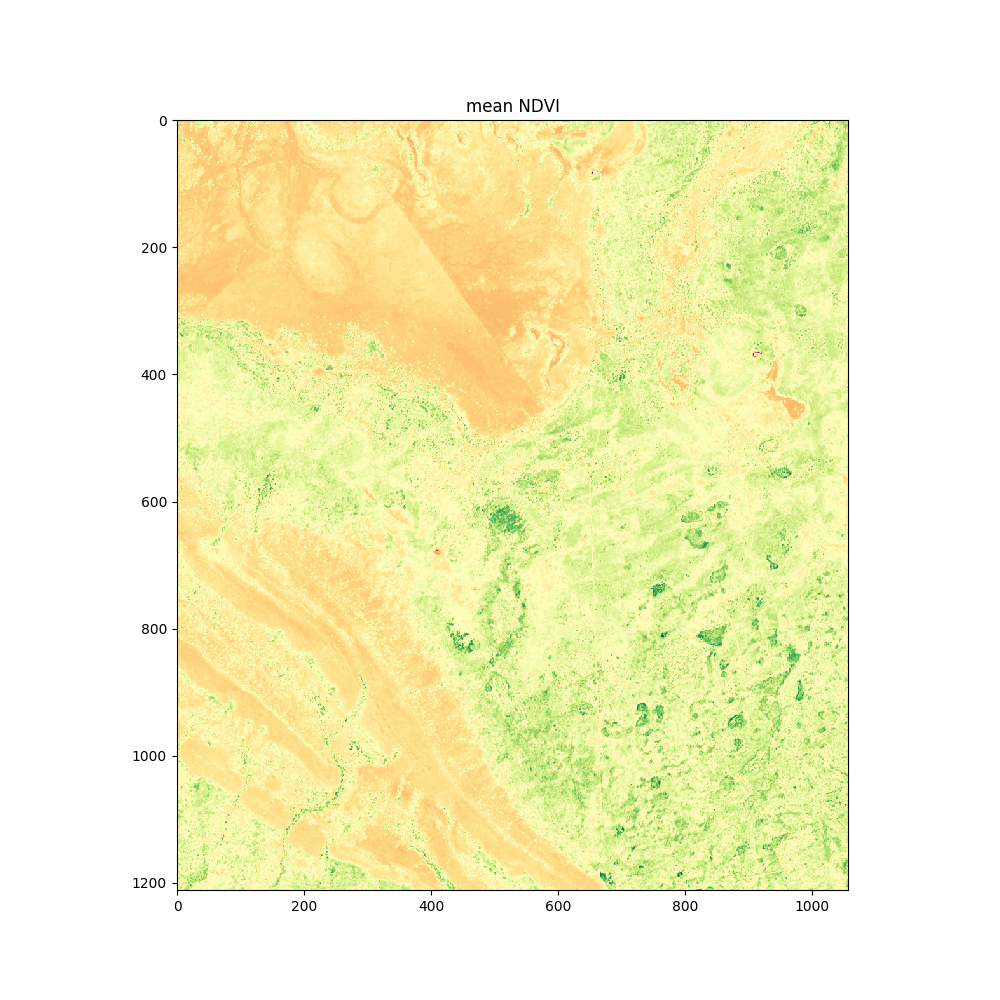

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('mean NDVI')
ax.imshow(cbr_NDVI, cmap='RdYlGn', interpolation='nearest')

plt.show()

In [ ]:
# this quiery retreives our data request entered in above cell
dc = datacube.Datacube()
query_ls = {
        'lat': (-30.70, -30.800),
        'lon': (144.900, 145.000),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2017-05-01', '2017-07-30')
        }
            
#this by defalt loads landsat 8 nbart albers data, print 'dc.list_products()' to see all avalible producst 

data_LS = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query_ls)

data_LS

In [ ]:
threeBandImage(data_LS, bands = ['red', 'green', 'blue'], time = 1)

In [ ]:
sentinal_data =


In [ ]:
threeBandImage(clear_data, bands = ['red', 'green', 'blue'], time = 3)

In [ ]:
import numpy as np